In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
from sklearn.datasets import make_blobs

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [7]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [8]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_) + (1. - y) * numpy.log(1-y_))
    
    if not avg:
        return d
    return numpy.mean(d)

In [9]:
def cost(w, x, y):
    return logreg_dist(y, x, w, avg=True)

logreg_rule = grad(cost)

In [10]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(w, x, y)

In [11]:
n_bases = 10
# select random centroids
cids = npr.permutation(len(x_tra))[:n_bases]
centroids = x_tra[cids]
x_tra_ = rbf(x_tra, centroids, 1.)


In [12]:
w0 = npr.randn(n_bases+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_logreg_dist, w0, (x_tra_, y_tra, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

In [13]:
print res
w = res.x

      fun: 1.4605423070713775e-05
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.39941643e-06,   1.78320865e-06,   2.16591456e-06,
         2.75813300e-06,   2.78424307e-06,   2.67836682e-06,
         2.75588131e-07,   2.89078240e-07,  -3.03472446e-07,
         2.09656696e-07,   6.52221478e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 17
      nit: 16
   status: 0
  success: True
        x: array([-13.29494403, -11.05016067, -11.11976646,  -9.93583729,
       -10.14320849, -13.41272761,   7.26404869,   3.73294624,
        14.26107554,   3.79747716,   7.90977092])


In [14]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [15]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


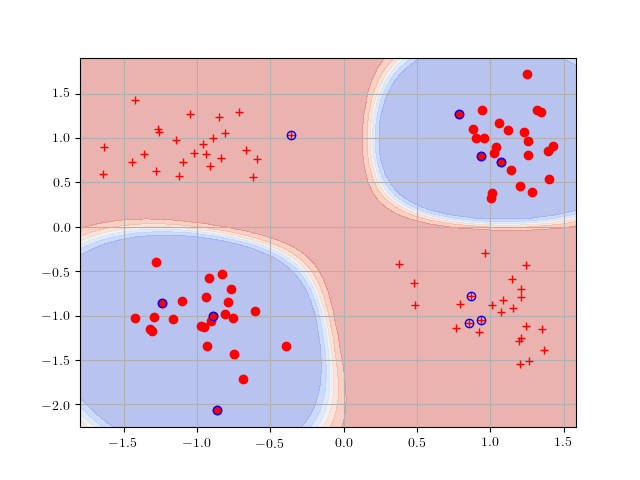

/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/Users/rossfreeman/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: MatplotlibD

In [19]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(centroids, None, c='b')

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [20]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_tes, centroids, 1.)

tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra_, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes_, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
